# Reproducible Challenge Project
### Alexander Svensson & Love Sundin
2025-10-21

### Introduction and Objective

The purpose of this project was to classify breast cancer tumors as either benign or malignant based on the characteristics of epithelial cells collected from biopsies. We used data from the University of Wisconsin Hospitals, and the process of data collection was described by Wolberg and Mangasarian in 1990 (https://doi.org/10.1073/pnas.87.23.9193). Wolberg and Mangasarian used the multi-surface method for classifying benign and malignant tumor in different stages. The data can be downloaded from the UC Irvine Machine Learning Repository: https://doi.org/10.24432/C5HP4Z.

In our project, we wanted to compare logistic regression with a neural network, to determine if there were complex interactions in the data that could not be captured by logistic regression. We also wanted to determine which cell characteristics were most important for determining if tumors were benign or malignant.

These two models were chosen they represent two different approaches. Logistic regression has only one parameter per variable, but is unable to find non-linear relationships. Neural networks have many more parameters and can find complex relationships between variables, but is more prone to overfitting. A neural network is also much more computationally heavy to train and use for predictions. The reason we choose to compare these two methods, was to see if there would be a significant difference in performance that would motivate the use of a more complex model. That would suggest that there are non-linear relationships between the independent variables that could not be captured by logistic regression. We where mainly interested in comparing accuracy and recall. Recall is more interesting than precision since it is important to miss as few malignant tumors as possible.

In total, there were 9 independent variables:

- Clump thickness: How many layers cell clumps contained.
- Uniformity of Cell Size
- Uniformity of Cell Shape
- Marginal adhesion: How much the surrounding cells would adhere to the cell clump.
- Single Epithelial Cell size: Diameter of the largest epithelial cell population in relation to the diameter of erythrocytes.
- Bare nuclei: Proportion of epithelial cell nuclei without cytoplasm.
- Bland Chromatin: To what extent the chromatin was smooth, in contrast to clumped.
- Normal nucleli: To what extent nuclei appeared normal.
- Mitoses: Frequency of mitosis.

These variables were encoded as discrete variables between 1 and 10.

### Data analysis and visualization

In [52]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import keras
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
import numpy as np
import keras_tuner
import shap
import statsmodels.api as sm

Data was read from the file "breast-cancer-wisconsin.data".

In [5]:
# Read input data and convert
column_names = [
    "Sample code number",
    "Clump Thickness",
    "Uniformity of Cell Size",
    "Uniformity of Cell Shape",
    "Marginal Adhesion",
    "Single Epithelial Cell Size",
    "Bare Nuclei",
    "Bland Chromatin",
    "Normal Nucleoli",
    "Mitoses",
    "Class"
]
class_dict = {2: "Benign", 4: "Malignant"}
input_df = pd.read_csv("Data files/breast-cancer-wisconsin.data", header=None, names=column_names, na_values=["?"])
input_df["Class"] = input_df["Class"].replace(class_dict)

In [24]:
input_df.head()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1.0,3,1,1,Benign
1,1002945,5,4,4,5,7,10.0,3,2,1,Benign
2,1015425,3,1,1,1,2,2.0,3,1,1,Benign
3,1016277,6,8,8,1,3,4.0,3,7,1,Benign
4,1017023,4,1,1,3,2,1.0,3,1,1,Benign


In [25]:
input_df.describe()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,683.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.544656,3.437768,2.866953,1.589413
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,3.643857,2.438364,3.053634,1.715078
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


Some rows had missing values for the variable bare nuclei. These rows were excluded from further analysis.

In [6]:
# Analyze which columns have missing values
print(input_df.isna().sum())
print(f'Shape original: {input_df.shape}')
# Drop rows with missing values
input_df = input_df.dropna()
print(f'Shape after drop: {input_df.shape}')

Sample code number              0
Clump Thickness                 0
Uniformity of Cell Size         0
Uniformity of Cell Shape        0
Marginal Adhesion               0
Single Epithelial Cell Size     0
Bare Nuclei                    16
Bland Chromatin                 0
Normal Nucleoli                 0
Mitoses                         0
Class                           0
dtype: int64
Shape original: (699, 11)
Shape after drop: (683, 11)


The remaining data was split into a training and test set.

In [7]:
# Split into training and test data
training_df, test_df = sklearn.model_selection.train_test_split(input_df, train_size=0.8, test_size=0.2, random_state=688712398)

The distribution of the independent variables was visualized with a violin plot and histograms for both classes. The violin plot shows the overall distribution of each variable. All variables have a center of mass at lower values. The histograms show how variables differ between the two classes.

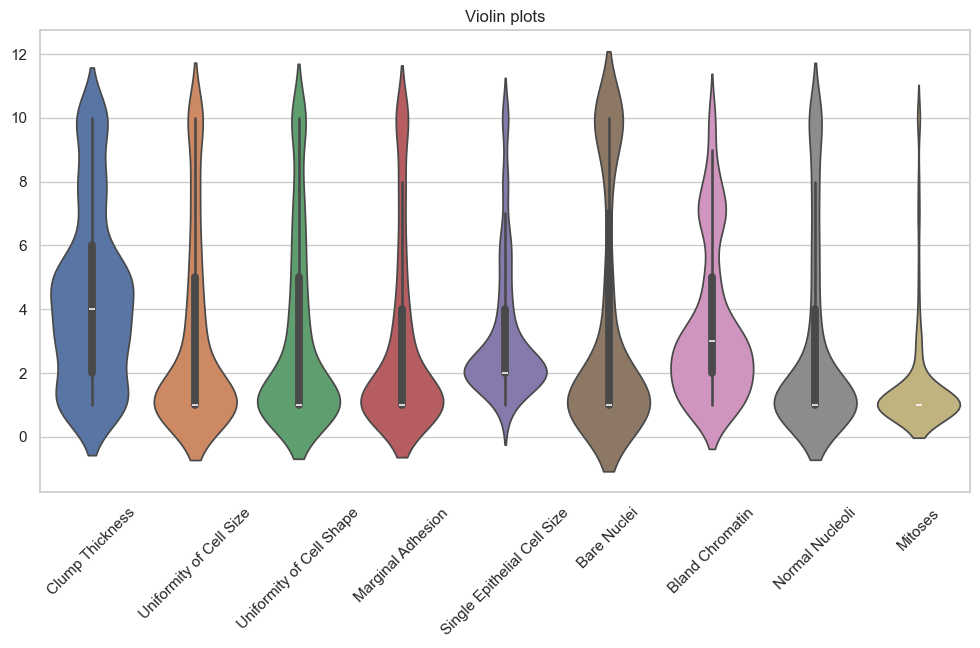

In [9]:
# List of all independent variables
independent_variables = [
    "Clump Thickness",
    "Uniformity of Cell Size",
    "Uniformity of Cell Shape",
    "Marginal Adhesion",
    "Single Epithelial Cell Size",
    "Bare Nuclei",
    "Bland Chromatin",
    "Normal Nucleoli",
    "Mitoses"
]

# Create violin plots showing the distribution of variables.
sns.set(style="whitegrid")
plt.figure(figsize=(12,6))
sns.violinplot(data=training_df[independent_variables], inner='box')
plt.xticks(rotation=45)
plt.title("Violin plots")
plt.show()

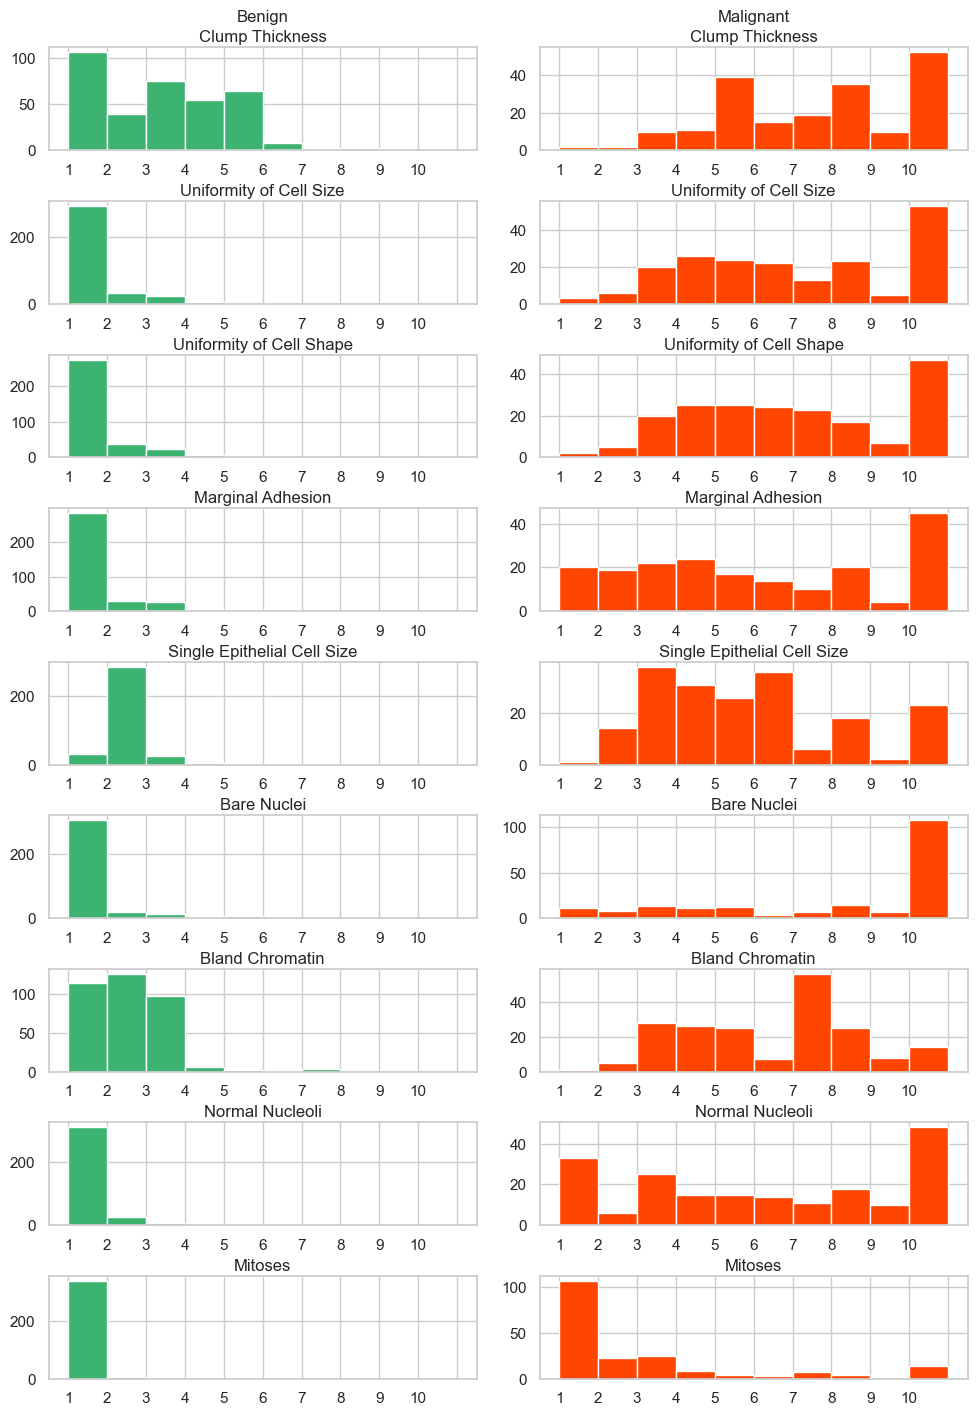

In [51]:
# Plot histograms for all independent variables

possible_classes = class_dict.values()

class_colors = ["mediumseagreen", "orangered"]

figure, axes = plt.subplots(9, 2)
figure.set_size_inches(10, 14)
figure.tight_layout()
bins = range(1, 12)
# Set titles
for class_index, tumor_class in enumerate(possible_classes):
    axis = axes[0, class_index]
    axis.set_title(tumor_class)
# Plot histograms
for variable_index, variable in enumerate(independent_variables):
    for class_index, tumor_class in enumerate(possible_classes):
        color = class_colors[class_index]
        axis = axes[variable_index][class_index]
        datapoints = training_df.query(f"Class == \"{tumor_class}\"")[variable]
        axis.hist(datapoints, color=color, bins=bins)
        axis.set_xlabel(variable)
        axis.xaxis.set_label_position('top')
        axis.set_xticks(bins, labels=list(bins[:-1])+[None])

These histograms show that higher values are more common in malignant tumors for all variables. It appears that there is a clear separation between benign and malignant, but there is some overlap for all variables.

A correlation matrix was plotted, to show linear correlations between independent variables. It showed that all independent variables had a positive correlation with eachother. High correlations between some variables, such as uniformity of cell size and uniformity of cell shape could make it harder to interpret SHAP values, as models can rely on either variable. High correlations could also increase variance in logistic regression without improving performance.

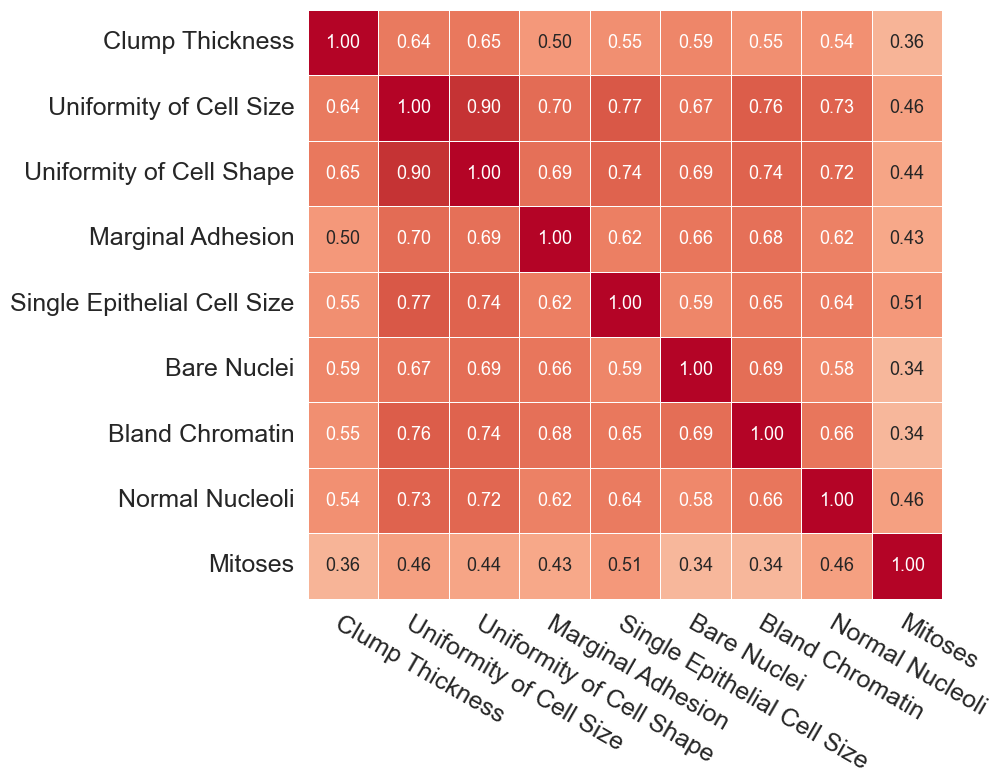

In [35]:
# Correlation matrix

predictors = training_df[independent_variables]
correlation_matrix = predictors.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1, annot_kws={'size': 13}, cbar=False)
axis=plt.gca()
for label in axis.get_xticklabels():
    label.set_rotation(-30)
    label.set_ha('left')
    label.set_rotation_mode('anchor')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
fig = plt.gcf()
plt.tight_layout()
plt.show()

The first two components from a support vector decomposition were plotted to visualize how the benign and malignant tumors differed. Benign tumors appeared more homogenous than malignant ones with these two components. Since the first principal component separates most benign and malignant tumors, logistic regression is expected to perform well.

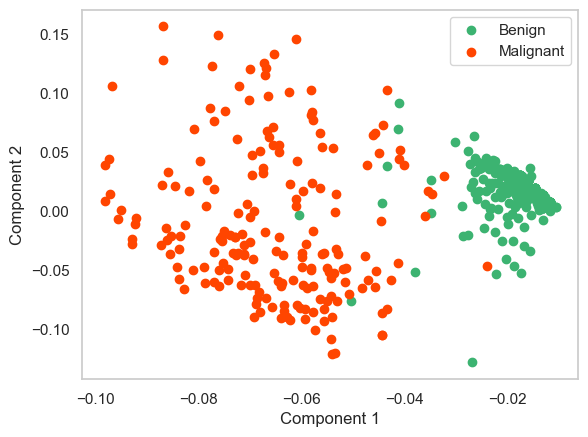

In [18]:
# SVD for the independent variables

U, S, Vt = np.linalg.svd(training_df[independent_variables], full_matrices=False)
figure, axis = plt.subplots()
benign_indices = training_df["Class"] == "Benign"
malignant_indices = training_df["Class"] == "Malignant"
axis.scatter(U[benign_indices, 0], U[benign_indices, 1], label="Benign", color = class_colors[0])
axis.scatter(U[malignant_indices, 0], U[malignant_indices, 1], label="Malignant", color = class_colors[1])
axis.set_xlabel("Component 1")
axis.set_ylabel("Component 2")
axis.legend()
axis.grid()
plt.show()

In [32]:
# Print principal components

print("Variable names:")
print(independent_variables)
for vector_index, vector in enumerate(Vt):
    print(f"Vector {vector_index+1}:")
    print(vector)

Variable names:
['Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses']
Vector 1:
[-0.40535667 -0.35236677 -0.35164606 -0.31222797 -0.30881103 -0.39458839
 -0.33741671 -0.31682991 -0.15838841]
Vector 2:
[ 0.3154522   0.15118542  0.09593571 -0.19738844  0.22871595 -0.82239157
 -0.01819026  0.2256831   0.22263061]
Vector 3:
[ 0.77844584 -0.25655825 -0.19117244 -0.26791821  0.01633013  0.16780232
 -0.00361665 -0.43575339 -0.03942691]
Vector 4:
[ 0.03534374  0.08631671  0.16454388 -0.73679916 -0.18349901  0.25068024
 -0.10957839  0.50538957 -0.2396123 ]
Vector 5:
[ 0.1284855  -0.45863988 -0.45975498  0.20002663 -0.1077472   0.09971521
 -0.1244231   0.57864626  0.38715689]
Vector 6:
[-0.23000551  0.07451535  0.05986943 -0.33223516  0.3815688   0.24940079
 -0.30808945 -0.22613542  0.68827941]
Vector 7:
[-0.23957121 -0.20426273 -0.30216364 -0.29434774  0.37861

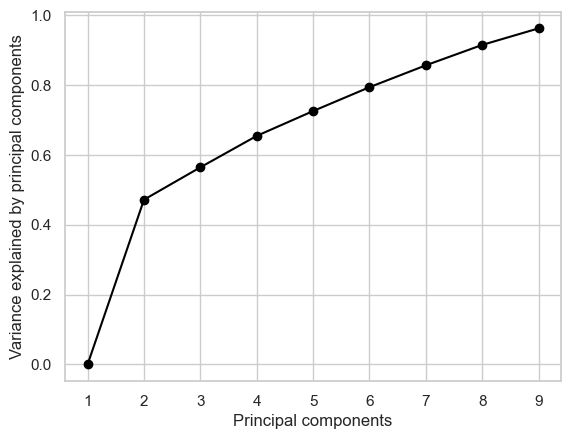

Cumulative sum of all components: 0.9627276207422694


In [22]:
# Variance explained

variance_proportion = [np.sum(S[:i]) / np.sum(S) for i in range(len(S))]
figure, axis = plt.subplots()
component_list = list(range(1, len(S)+1))
axis.plot(component_list, variance_proportion, "o", linestyle="-", color="black")
axis.set_xticks(component_list)
axis.set_xlabel("Principal components")
axis.set_ylabel("Variance explained by principal components")
axis.grid(True)
plt.show()
print("Cumulative sum of all components:", variance_proportion[-1])

The plot showing cumulative variance explained shows that the first principal component explains almost half of the variance between independent variables. The other components explain a similar amount of variance.

### Model Development

In preparation for modeling, the output variable was encoded as a binary variable that is 0 if the tumor is benign and 1 if it is malignant.

In [64]:
# Dictionary for encoding "Benign" as 0 and "Malignant" as 1
encoding_dict = {"Benign": 0, "Malignant": 1}

# Split into x and y set and encode
x_train = training_df[independent_variables]
y_train = training_df["Class"].replace(encoding_dict).infer_objects(copy=False)
x_test = test_df[independent_variables]
y_test = test_df["Class"].replace(encoding_dict).infer_objects(copy=False)

/tmp/ipykernel_4162/2548434494.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = training_df["Class"].replace(encoding_dict).infer_objects(copy=False)
/tmp/ipykernel_4162/2548434494.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test = test_df["Class"].replace(encoding_dict).infer_objects(copy=False)


Bayesian optimization was used to find the optimal hyperparameters for a neural network. The following hyperparameters were tested in the specified ranges:

- Number of layers: $[1, 2]$
- Nodes in layer 1: $[4, 64]$ with steps of 4
- Nodes in layer 2: $[4, 64]$ with steps of 4
- Dropout rate: $[0, 0.5]$

For all models, we used a training rate of 0.01 with the Adam optimizer and a batch size of 32. 50 different models were trained with the tuner with 12 initial random trials. Early stopping was used to prevent overfitting. Binary cross-entropy from five-fold crossvalidation was used as the evaluation metric.

In [65]:
# Function for building a model with the given hyperparameters
def build_model(hyperparameters):
    # Get hyperparameters
    layers = hyperparameters.Int('layers', min_value=1, max_value=2, step=1)
    dropout_rate = hyperparameters.Float("dropout rate", min_value=0, max_value=0.5)
    layer_nodes = []
    layer_nodes.append(hyperparameters.Int("layer 1 nodes", min_value=4,max_value=64, step=4))
    layer_nodes.append(hyperparameters.Int("layer 2 nodes", min_value=4, max_value=64, step=4))

    # Build network one layer at a time
    simple_network = keras.Sequential()
    simple_network.add(keras.layers.Input(shape=(len(independent_variables),)))
    for layer in range(layers):
        simple_network.add(keras.layers.Dense(layer_nodes[layer], activation="relu"))
        if dropout_rate>0:
            simple_network.add(keras.layers.Dropout(dropout_rate))
    simple_network.add(keras.layers.Dense(1, activation="sigmoid"))
    
    # Compile and return network
    simple_network.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-2),
        loss="binary_crossentropy", metrics=["accuracy", "precision", "recall"])
    return simple_network

In [ ]:
# Perform Bayesian optimization with Keras Tuner
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective='val_loss',
    executions_per_trial=2,
    directory='Hyperparameter tuning',
    overwrite=True,
    max_trials=50,
    num_initial_points=12,
    project_name='Tumor classification network',
    seed=1879214189
)
early_stopping=keras.callbacks.EarlyStopping("val_loss", patience=5, restore_best_weights=True)
tuner.search(x_train, y_train,
             batch_size=32,
             validation_split=0.2,
             epochs=200, 
             callbacks=[early_stopping])

Trial 50 Complete [00h 00m 19s]
val_loss: 0.03139762673527002

Best val_loss So Far: 0.027721446938812733
Total elapsed time: 00h 15m 02s


In [ ]:
# Get best hyperparameters

best_hyperparameters=tuner.get_best_hyperparameters()[0]
print("Best values of hyperparameters:")
for parameter_name, parameter_value in best_hyperparameters.values.items():
    print(f"{parameter_name}: {parameter_value}")

Best values of hyperparameters:
layers: 2
dropout rate: 0.35966677190794083
layer 1 nodes: 52
layer 2 nodes: 24


The best model had 2 layers with 24 and 52 nodes respectively, and a dropout rate of about 0.360. A new model was trained with these parameters. It was saved and used for further analysis. The change in binary crossentropy and accuracy during training was plotted.

In [ ]:
# Train a new model with the best hyperparameters

optimized_model = tuner.hypermodel.build(best_hyperparameters)
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
history = optimized_model.fit(x_train, y_train, epochs=200, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
# Save model
optimized_model.save("optimized_model.keras")

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.5882 - loss: 0.7897 - precision: 0.4102 - recall: 0.6087 - val_accuracy: 0.9182 - val_loss: 0.4053 - val_precision: 0.8049 - val_recall: 0.9706
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8523 - loss: 0.4151 - precision: 0.7578 - recall: 0.9342 - val_accuracy: 0.9636 - val_loss: 0.2139 - val_precision: 0.9167 - val_recall: 0.9706
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8855 - loss: 0.2923 - precision: 0.8410 - recall: 0.8397 - val_accuracy: 0.9364 - val_loss: 0.1476 - val_precision: 0.8462 - val_recall: 0.9706
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9422 - loss: 0.2102 - precision: 0.9442 - recall: 0.8984 - val_accuracy: 0.9545 - val_loss: 0.1042 - val_precision: 0.8919 - val_recall: 0.9706
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9329 - loss: 0.2107 - precision: 0.9101 - recall: 0.9134 - val_accuracy: 0.9545 - val_loss: 0.113

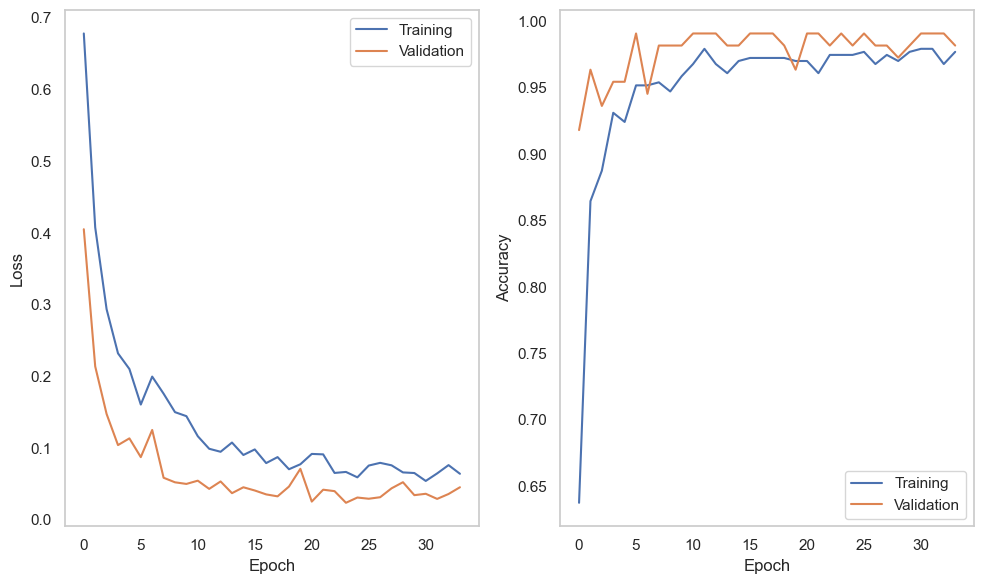

In [ ]:
figure, axes = plt.subplots(1, 2)

# Print loss (binary crossentropy) during training
axis=axes[0]
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
axis.plot(training_loss, label="Training")
axis.plot(validation_loss, label="Validation")
axis.grid()
axis.legend()
axis.set_xlabel("Epoch")
axis.set_ylabel("Loss")

# Print accuracy during training
axis = axes[1]
training_accuracy = history.history["accuracy"]
validation_accuracy = history.history["val_accuracy"]
axis.plot(training_accuracy, label="Training")
axis.plot(validation_accuracy, label="Validation")
axis.grid()
axis.legend()
axis.set_xlabel("Epoch")
axis.set_ylabel("Accuracy")

figure.set_size_inches(10, 6)
figure.tight_layout()

plt.show()

The performance of this model on test data was evaluated with a confusion matrix. The accuracy was 0.94.

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        93
           1       0.89      0.93      0.91        44

    accuracy                           0.94       137
   macro avg       0.93      0.94      0.93       137
weighted avg       0.94      0.94      0.94       137

Train accuracy: 0.9853479853479854
Test accuracy: 0.9416058394160584


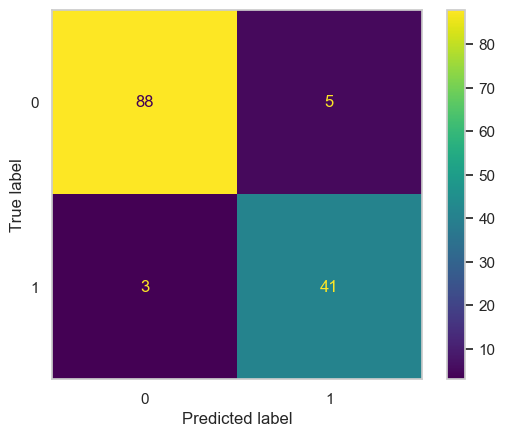

In [ ]:
# Load best model
optimized_model = keras.saving.load_model("optimized_model.keras", custom_objects=None, compile=True, safe_mode=True)

# Get predictions
y_pred_prob = optimized_model.predict(x_test)
y_pred = (y_pred_prob >= 0.5).astype(int)
y_pred_prob_train = optimized_model.predict(x_train)
y_pred_train = (y_pred_prob_train >= 0.5).astype(int)

# Calculate performance metrics
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
axis = plt.gca()
axis.grid(False)

print(classification_report(y_test, y_pred))
print("Train accuracy:", accuracy_score(y_train, y_pred_train))
print("Test accuracy:", accuracy_score(y_test, y_pred))

Shap values were calculated to show which values were most important. X values correspond to how much the variable contributed to the prediction and colors correspond to the value of the variable. For example, lower values for "Bare Nuclei" corresponds to a lower probability of a tumor being malignant. The three most important variables were bare nuclei, uniformity of cell size and uniformity of cell shape.

In [ ]:
# Calculate SHAP values for best model

explainer = shap.KernelExplainer(optimized_model.predict, x_train)
shap_values = explainer.shap_values(x_test, nsamples=100)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Using 546 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/137 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


  1%|          | 1/137 [00:03<06:54,  3.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


  1%|▏         | 2/137 [00:06<06:55,  3.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


  2%|▏         | 3/137 [00:08<06:36,  2.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


  3%|▎         | 4/137 [00:12<06:54,  3.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


  4%|▎         | 5/137 [00:15<06:56,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


  4%|▍         | 6/137 [00:19<07:25,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


  5%|▌         | 7/137 [00:22<07:25,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


  6%|▌         | 8/137 [00:25<06:52,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


  7%|▋         | 9/137 [00:28<06:31,  3.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


  7%|▋         | 10/137 [00:30<06:02,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


  8%|▊         | 11/137 [00:33<05:44,  2.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


  9%|▉         | 12/137 [00:35<05:30,  2.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


  9%|▉         | 13/137 [00:38<05:30,  2.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 10%|█         | 14/137 [00:41<05:34,  2.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 11%|█         | 15/137 [00:44<05:42,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 12%|█▏        | 16/137 [00:46<05:38,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 12%|█▏        | 17/137 [00:50<05:43,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 13%|█▎        | 18/137 [00:53<05:58,  3.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 14%|█▍        | 19/137 [00:56<06:09,  3.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 15%|█▍        | 20/137 [01:00<06:16,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 15%|█▌        | 21/137 [01:02<05:54,  3.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


 16%|█▌        | 22/137 [01:06<05:57,  3.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 17%|█▋        | 23/137 [01:09<05:58,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 18%|█▊        | 24/137 [01:12<05:46,  3.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 18%|█▊        | 25/137 [01:15<05:40,  3.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 19%|█▉        | 26/137 [01:17<05:18,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 20%|█▉        | 27/137 [01:20<04:58,  2.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 995us/step


 20%|██        | 28/137 [01:22<04:44,  2.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 21%|██        | 29/137 [01:25<04:43,  2.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 22%|██▏       | 30/137 [01:27<04:42,  2.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 23%|██▎       | 31/137 [01:30<04:46,  2.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 23%|██▎       | 32/137 [01:33<04:40,  2.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 24%|██▍       | 33/137 [01:36<04:54,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 25%|██▍       | 34/137 [01:39<05:14,  3.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 26%|██▌       | 35/137 [01:42<04:53,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 26%|██▋       | 36/137 [01:44<04:38,  2.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 925us/step


 27%|██▋       | 37/137 [01:47<04:18,  2.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 910us/step


 28%|██▊       | 38/137 [01:49<04:04,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 927us/step


 28%|██▊       | 39/137 [01:51<03:53,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 925us/step


 29%|██▉       | 40/137 [01:53<03:44,  2.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 934us/step


 30%|██▉       | 41/137 [01:55<03:40,  2.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 31%|███       | 42/137 [01:58<03:48,  2.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 31%|███▏      | 43/137 [02:01<04:08,  2.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 32%|███▏      | 44/137 [02:04<04:13,  2.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 33%|███▎      | 45/137 [02:07<04:06,  2.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 34%|███▎      | 46/137 [02:09<03:54,  2.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 34%|███▍      | 47/137 [02:12<03:51,  2.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 35%|███▌      | 48/137 [02:14<03:44,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 36%|███▌      | 49/137 [02:17<03:39,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 964us/step


 36%|███▋      | 50/137 [02:19<03:31,  2.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 37%|███▋      | 51/137 [02:21<03:29,  2.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 979us/step


 38%|███▊      | 52/137 [02:23<03:22,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 39%|███▊      | 53/137 [02:26<03:30,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 995us/step


 39%|███▉      | 54/137 [02:29<03:24,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 1s 870us/step


 40%|████      | 55/137 [02:31<03:13,  2.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 41%|████      | 56/137 [02:33<03:20,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 42%|████▏     | 57/137 [02:36<03:24,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 42%|████▏     | 58/137 [02:39<03:23,  2.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 43%|████▎     | 59/137 [02:41<03:22,  2.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 44%|████▍     | 60/137 [02:44<03:17,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 45%|████▍     | 61/137 [02:46<03:10,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 939us/step


 45%|████▌     | 62/137 [02:49<03:02,  2.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 46%|████▌     | 63/137 [02:51<03:06,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 47%|████▋     | 64/137 [02:54<03:00,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 47%|████▋     | 65/137 [02:56<02:59,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 48%|████▊     | 66/137 [02:59<02:54,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 970us/step


 49%|████▉     | 67/137 [03:01<02:47,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 50%|████▉     | 68/137 [03:04<02:51,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 954us/step


 50%|█████     | 69/137 [03:06<02:48,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 51%|█████     | 70/137 [03:09<02:46,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 52%|█████▏    | 71/137 [03:11<02:45,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 892us/step


 53%|█████▎    | 72/137 [03:13<02:37,  2.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step


 53%|█████▎    | 73/137 [03:15<02:27,  2.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 878us/step


 54%|█████▍    | 74/137 [03:18<02:23,  2.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 55%|█████▍    | 75/137 [03:20<02:28,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 55%|█████▌    | 76/137 [03:23<02:26,  2.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 960us/step


 56%|█████▌    | 77/137 [03:25<02:21,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 981us/step


 57%|█████▋    | 78/137 [03:27<02:18,  2.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 58%|█████▊    | 79/137 [03:30<02:17,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 58%|█████▊    | 80/137 [03:32<02:14,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 964us/step


 59%|█████▉    | 81/137 [03:34<02:09,  2.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 60%|█████▉    | 82/137 [03:37<02:10,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 980us/step


 61%|██████    | 83/137 [03:39<02:08,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 61%|██████▏   | 84/137 [03:42<02:11,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 62%|██████▏   | 85/137 [03:44<02:11,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 63%|██████▎   | 86/137 [03:47<02:11,  2.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 64%|██████▎   | 87/137 [03:51<02:23,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 64%|██████▍   | 88/137 [03:53<02:12,  2.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 927us/step


 65%|██████▍   | 89/137 [03:55<02:01,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 937us/step


 66%|██████▌   | 90/137 [03:57<01:54,  2.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 931us/step


 66%|██████▋   | 91/137 [04:00<01:48,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 942us/step


 67%|██████▋   | 92/137 [04:02<01:46,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 68%|██████▊   | 93/137 [04:05<01:52,  2.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 69%|██████▊   | 94/137 [04:08<01:50,  2.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 69%|██████▉   | 95/137 [04:11<01:56,  2.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 70%|███████   | 96/137 [04:13<01:50,  2.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 71%|███████   | 97/137 [04:16<01:47,  2.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 72%|███████▏  | 98/137 [04:19<01:43,  2.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 893us/step


 72%|███████▏  | 99/137 [04:21<01:35,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 73%|███████▎  | 100/137 [04:23<01:31,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 74%|███████▎  | 101/137 [04:26<01:29,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 74%|███████▍  | 102/137 [04:28<01:27,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 75%|███████▌  | 103/137 [04:31<01:24,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 76%|███████▌  | 104/137 [04:33<01:21,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 77%|███████▋  | 105/137 [04:35<01:19,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 77%|███████▋  | 106/137 [04:38<01:20,  2.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 78%|███████▊  | 107/137 [04:41<01:21,  2.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 79%|███████▉  | 108/137 [04:44<01:18,  2.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 80%|███████▉  | 109/137 [04:47<01:17,  2.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 80%|████████  | 110/137 [04:50<01:18,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 81%|████████  | 111/137 [04:53<01:15,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 82%|████████▏ | 112/137 [04:56<01:13,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 82%|████████▏ | 113/137 [04:59<01:09,  2.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 83%|████████▎ | 114/137 [05:02<01:05,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 84%|████████▍ | 115/137 [05:04<01:02,  2.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 85%|████████▍ | 116/137 [05:07<00:59,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 85%|████████▌ | 117/137 [05:10<00:55,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 86%|████████▌ | 118/137 [05:13<00:53,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 87%|████████▋ | 119/137 [05:15<00:49,  2.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 88%|████████▊ | 120/137 [05:18<00:45,  2.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 88%|████████▊ | 121/137 [05:20<00:41,  2.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 954us/step


 89%|████████▉ | 122/137 [05:23<00:37,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 90%|████████▉ | 123/137 [05:25<00:34,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 91%|█████████ | 124/137 [05:28<00:32,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 91%|█████████ | 125/137 [05:30<00:30,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 92%|█████████▏| 126/137 [05:33<00:28,  2.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 93%|█████████▎| 127/137 [05:35<00:25,  2.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 93%|█████████▎| 128/137 [05:38<00:23,  2.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 94%|█████████▍| 129/137 [05:41<00:20,  2.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 95%|█████████▍| 130/137 [05:43<00:17,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 975us/step


 96%|█████████▌| 131/137 [05:45<00:14,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 96%|█████████▋| 132/137 [05:48<00:12,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 97%|█████████▋| 133/137 [05:50<00:10,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 98%|█████████▊| 134/137 [05:53<00:07,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 99%|█████████▊| 135/137 [05:55<00:04,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


 99%|█████████▉| 136/137 [05:58<00:02,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


100%|██████████| 137/137 [06:00<00:00,  2.63s/it]


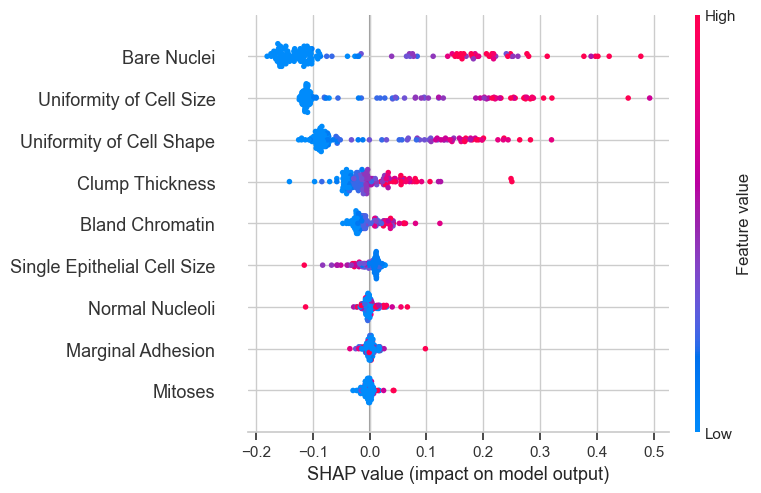

In [ ]:
# Plot SHAP values for network
shap.summary_plot(shap_values[:, :, 0], x_test, feature_names=independent_variables)

As a baseline, a model always prediction benign, which was the most common class, was also trained. This model had an accuracy of 0.68.

              precision    recall  f1-score   support

           0       0.68      1.00      0.81        93
           1       0.00      0.00      0.00        44

    accuracy                           0.68       137
   macro avg       0.34      0.50      0.40       137
weighted avg       0.46      0.68      0.55       137



/home/love/Programs/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/love/Programs/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/love/Programs/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

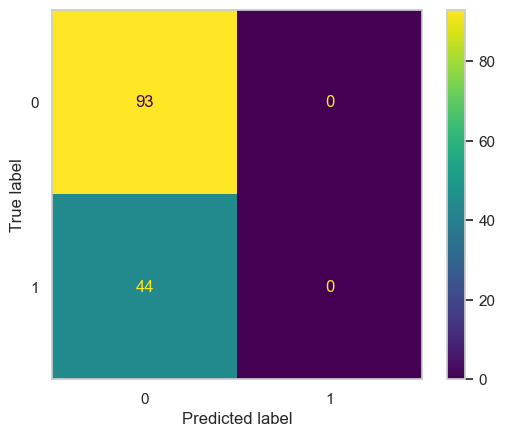

In [ ]:
# Performance of model always predicting benign, the most common class
y_pred_majority_class = np.zeros(len(x_test))

cm = confusion_matrix(y_test, y_pred_majority_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
axis = plt.gca()
axis.grid(False)

print(classification_report(y_test, y_pred_majority_class))

As a comparison to the neural network, logistic regression was also performed. This was done with the `statsmodels` package.

In [ ]:
# Train logistic regression model
X_sm = sm.add_constant(x_train)
model_sm = sm.Logit(y_train, X_sm)
result = model_sm.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.051771
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Class   No. Observations:                  546
Model:                          Logit   Df Residuals:                      536
Method:                           MLE   Df Model:                            9
Date:                Tue, 21 Oct 2025   Pseudo R-squ.:                  0.9206
Time:                        15:44:36   Log-Likelihood:                -28.267
converged:                       True   LL-Null:                       -355.86
Covariance Type:            nonrobust   LLR p-value:                2.960e-135
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                         -10.5180      1.458     -7.213      0.000     -13.376      -7.660
Clump Thickness                 0.4606      0.212      2.171      0.030       0.045       0.876
Uniformity of Cell Size         0.5880      0.357      1.649      0.099      -0.111       1.287
Uniformity of Cell Shape        0.5038      0.350      1.438      0.150      -0.183       1.190
Marginal Adhesion               0.1912      0.164      1.163      0.245      -0.131       0.514
Single Epithelial Cell Size     0.0286      0.216      0.132      0.895      -0.394       0.451
Bare Nuclei                     0.5594      0.146      3.820      0.000       0.272       0.846
Bland Chromatin                 0.3529      0.248      1.424      0.154      -0.133       0.839
Normal Nucleoli                -0.0379      0.169     -0.224      0.823      -0.370       0.294
Mitoses                         0.2500      0.324      0.772      0.440      -0.385       0.885
===============================================================================================

Possibly complete quasi-separation: A fraction 0.12 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [ ]:
odds_ratios = np.exp(result.params)
print("Odds ratios:")
print(odds_ratios)

Odds ratios:
const                          0.000027
Clump Thickness                1.585013
Uniformity of Cell Size        1.800329
Uniformity of Cell Shape       1.655081
Marginal Adhesion              1.210738
Single Epithelial Cell Size    1.028969
Bare Nuclei                    1.749691
Bland Chromatin                1.423155
Normal Nucleoli                0.962823
Mitoses                        1.284021
dtype: float64


The parameters from the logistic regression are shown above with p-values and confidence intervals. The odds ratio of each parameter is also shown. The only parameters that were significantly different from 0 at a confidence level of 0.05 were the intercept, clump thickness and bare nuclei. The model was evaluated on test data and achieved an accuracy of 0.92. A confusion matrix is shown below.

In [ ]:
# Predict with logistic regression
X_sm_test = sm.add_constant(x_test)
y_sm_pred_prob_test = result.predict(X_sm_test)
y_sm_pred_test = (y_sm_pred_prob_test >= 0.5).astype(int)

y_sm_pred_prob_train = result.predict(X_sm)
y_sm_pred_train = (y_sm_pred_prob_train >= 0.5).astype(int)

# Calculate performance metrics
print("Accuracy:", accuracy_score(y_test, y_sm_pred_test))
print("\nClassification report:\n", classification_report(y_test, y_sm_pred_test))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_sm_pred_test))

print("Train accuracy:", accuracy_score(y_train, y_sm_pred_train))
print("Test accuracy:", accuracy_score(y_test, y_sm_pred_test))

Accuracy: 0.9197080291970803

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94        93
           1       0.88      0.86      0.87        44

    accuracy                           0.92       137
   macro avg       0.91      0.90      0.91       137
weighted avg       0.92      0.92      0.92       137


Confusion matrix:
 [[88  5]
 [ 6 38]]
Train accuracy: 0.9835164835164835
Test accuracy: 0.9197080291970803


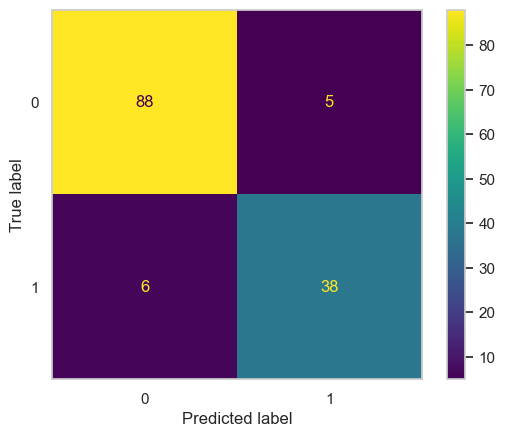

In [ ]:
# Confusion matrix for logistic regression
cm = confusion_matrix(y_test, y_sm_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
axis = plt.gca()
axis.grid(False)

SHAP values were calculated for the logistic regression model, showing that variable importance was similar.

Using 546 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 137/137 [00:01<00:00, 97.72it/s] 


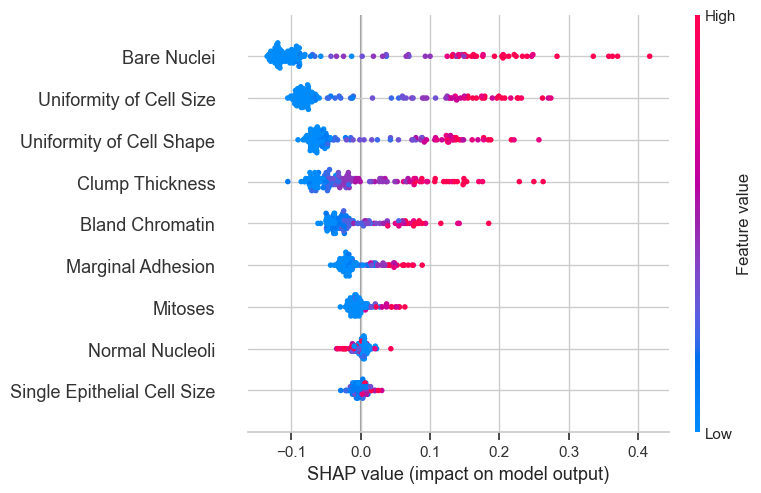

In [ ]:
# SHAP values for logistic regression
explainer = shap.KernelExplainer(result.predict, X_sm)
shap_values = explainer.shap_values(X_sm_test, nsamples=100)
axis = shap.summary_plot(shap_values[:,1:], x_test, feature_names=independent_variables, sort=True)

Since only two parameters were significantly different from 0, a reduced model with only the parameters bare nuclei and clump thickness was trained. A confusion matrix for this model is shown below.

In [67]:
# Define new variable sets for the reduced model
x_train_reduced_model = x_train[['Clump Thickness', 'Bare Nuclei']]
x_test_reduced_model = x_test[['Clump Thickness', 'Bare Nuclei']]

# Train reduced model
X_sm = sm.add_constant(x_train_reduced_model)
model_sm = sm.Logit(y_train, X_sm)
result = model_sm.fit()

# Get predictions from reduced model
X_sm_test = sm.add_constant(x_test_reduced_model)
y_sm_pred_prob_test = result.predict(X_sm_test)
y_sm_pred_test = (y_sm_pred_prob_test >= 0.5).astype(int)

y_sm_pred_prob_train = result.predict(X_sm)
y_sm_pred_train = (y_sm_pred_prob_train >= 0.5).astype(int)

# Performance metrics
print("Accuracy:", accuracy_score(y_test, y_sm_pred_test))
print("\nClassification report:\n", classification_report(y_test, y_sm_pred_test))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_sm_pred_test))

print("Train accuracy:", accuracy_score(y_train, y_sm_pred_train))
print("Test accuracy:", accuracy_score(y_test, y_sm_pred_test))

Optimization terminated successfully.
         Current function value: 0.120036
         Iterations 9
Accuracy: 0.9197080291970803

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94        93
           1       0.87      0.89      0.88        44

    accuracy                           0.92       137
   macro avg       0.91      0.91      0.91       137
weighted avg       0.92      0.92      0.92       137


Confusion matrix:
 [[87  6]
 [ 5 39]]
Train accuracy: 0.9560439560439561
Test accuracy: 0.9197080291970803


In [ ]:
# Summarize reduced model
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Class   No. Observations:                  546
Model:                          Logit   Df Residuals:                      543
Method:                           MLE   Df Model:                            2
Date:                Tue, 21 Oct 2025   Pseudo R-squ.:                  0.8158
Time:                        15:53:23   Log-Likelihood:                -65.540
converged:                       True   LL-Null:                       -355.86
Covariance Type:            nonrobust   LLR p-value:                8.240e-127
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -8.7535      0.936     -9.353      0.000     -10.588      -6.919
Clump Thickness     1.0583      0.149      7.102      0.000       0.766       1.350
Bare Nuclei         0.9152      0.108      8.480      0.000       0.704       1.127
===================================================================================
"""

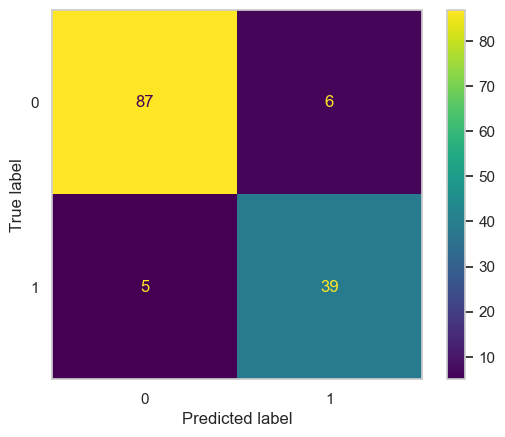

In [ ]:
# Confusion matrix for reduced model
cm = confusion_matrix(y_test, y_sm_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
axis = plt.gca()
axis.grid(False)

The reduced model had the same accuracy, slightly lower precision and slightly higher recall.

Finally, the misclassifications from the neural network and reduced logistic regression model were investigated. All test data was plotted after conversion to the first two principal components from the support vector decomposition done for the training data. Misclassifications with the neural network and logistic regression model are shown.

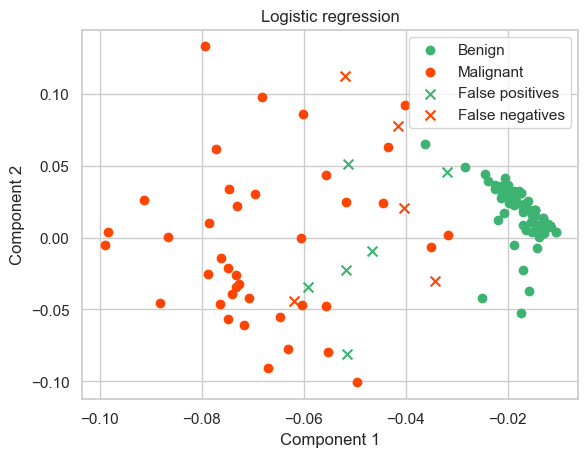

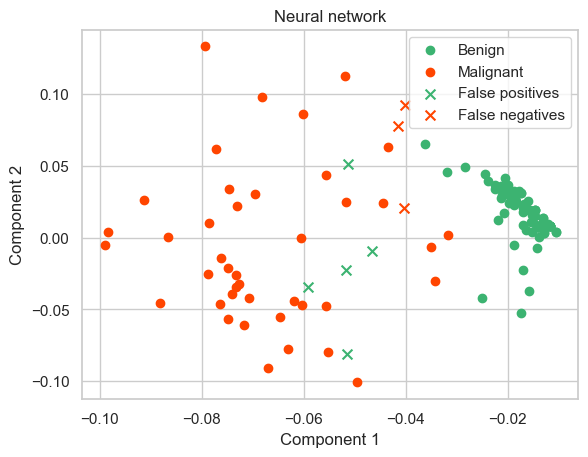

In [68]:
# Investigate misclassified

# Get indices of misclassifications
logistic_fn = (y_test==1) * (y_sm_pred_test==0)
logistic_fp = (y_test==0) * (y_sm_pred_test==1)

network_fn = (y_test==1) * (y_pred[:,0]==0)
network_fp = (y_test==0) * (y_pred[:,0]==1)

# Get matrix for transforming to principal components
transform_matrix = Vt.T/S

benign_indices = test_df["Class"] == "Benign"
malignant_indices = test_df["Class"] == "Malignant"

# Print logistic errors
figure, axis = plt.subplots()
# Indices of correctly classified points
benign_correct = benign_indices * ~logistic_fp
malignant_correct = malignant_indices * ~logistic_fn
# Scatter plots of correct and incorrect points
axis.scatter((x_test[benign_correct]@transform_matrix)[0], (x_test[benign_correct]@transform_matrix)[1], label="Benign", color = class_colors[0])
axis.scatter((x_test[malignant_correct]@transform_matrix)[0], (x_test[malignant_correct]@transform_matrix)[1], label="Malignant", color = class_colors[1])
axis.scatter((x_test[logistic_fp]@transform_matrix)[0], (x_test[logistic_fp]@transform_matrix)[1], label="False positives", color=class_colors[0], marker="x", s=50)
axis.scatter((x_test[logistic_fn]@transform_matrix)[0], (x_test[logistic_fn]@transform_matrix)[1], label="False negatives", color=class_colors[1], marker="x", s=50)
axis.set_xlabel("Component 1")
axis.set_ylabel("Component 2")
axis.legend()
axis.grid(True)
axis.set_title("Logistic regression")
plt.show()

# Plot neural network errors
figure, axis = plt.subplots()
# Indices of correctly classified points
benign_correct = benign_indices * ~network_fp
malignant_correct = malignant_indices * ~network_fn
# Scatter plots of correct and incorrect points
axis.scatter((x_test[benign_correct]@transform_matrix)[0], (x_test[benign_correct]@transform_matrix)[1], label="Benign", color = class_colors[0])
axis.scatter((x_test[malignant_correct]@transform_matrix)[0], (x_test[malignant_correct]@transform_matrix)[1], label="Malignant", color = class_colors[1])
axis.scatter((x_test[network_fp]@transform_matrix)[0], (x_test[network_fp]@transform_matrix)[1], label="False positives", color=class_colors[0], marker="x", s=50)
axis.scatter((x_test[network_fn]@transform_matrix)[0], (x_test[network_fn]@transform_matrix)[1], label="False negatives", color=class_colors[1], marker="x", s=50)
axis.set_xlabel("Component 1")
axis.set_ylabel("Component 2")
axis.legend()
axis.grid(True)
axis.set_title("Neural network")
plt.show()

The plot of misclassifications transformed to the first principal components shows that all points misclassified by the neural network were also misclassified by the logistic regression model. Most misclassifications are near the edge between benign and malignant datapoints on principal component one.

### Graph styles

Graph styles were chosen to be clear and not include redundant information. Colors are used to differentiate between the two classes in scatter plots and histograms and to show if values are high or low in correlation matrices, confusion matrices and SHAP value plots. In the plots showing misclassifications, we use shapes to separate correct from incorrect predictions. We use axis titles to show which variables are plotted. Titles are only used when they necessary to separate between plots, and when the information in the axis labels is insufficient. Grids were added when relevant.

### FAIR principles

This workflow adheres to the FAIR principles. Here is how we have made it adhere to these principles:

* __F__ - Findable:
In order to make sure the data and workflow is findable it should be easy to find both for humans and computers. Hence the workflow is available at [Github](https://github.com/18alle18/Reproducible-Challenge-Project) with a README and the following keywords: $\texttt{neural-network}$, $\texttt{logistic-regression}$ and $\texttt{breast-cancer-prediction}$. The article which the data used stems from is linked to with a DOI, and a DOI is also used to link to the original data.

* __A__ - Accessible:
For accessibility, the notebook is uploaded on Github with an MIT licence allowing other to freely preview, download and use any part of it. The data is also available to download as a CSV file. The README file explains how to use the notebook, explains the data, lists the license and links to the original dataset. CSV and notebook files are open source formats.

* __I__ - Interoperable:
The original data is included in the Github repository as a CSV file. The code is in a Jupyter notebook file, which is in the JSON format. Since it is written in Python, is is easy to adapt the code to other projects.

* __R__ - Reusable:
A comprehensive readme file is included. This file describes the general process, what the different files contain and what is included in the data files. The project uses an MIT license, making it possible to use the code in any project. All code is in a Jupyter notebook file with plenty of documentation, making it easy to run, edit and understand.